In [1]:
#import libraries
import pandas as pd
import numpy as np
import time
import collections
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import nltk
import ssl
import re
import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn import feature_selection, feature_extraction, naive_bayes, pipeline, metrics

#SSL error fix
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

#download corpuses
nltk.download('stopwords')
nltk.download('omw-1.4')

#command to install pip packages in jupyter
#!{sys.executable} -m pip install [package]


/home/riku/snap/jupyter/common/lib/python3.7/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/riku/snap/jupyter/6/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/riku/snap/jupyter/6/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
#process large data in chunks
#NOT USED
'''chunksize = 10 ** 6
cols = ['subreddit', 'body ']
data = collections.defaultdict(list)
chunks = 0
with pd.read_csv('politics25.tsv', chunksize=chunksize, sep='\t', usecols=cols) as reader:
    for chunk in reader:
        for i, row in chunk.iterrows():
            data[row['subreddit']].append(row['body '])
        chunks += 1 
print(chunks)
'''

"chunksize = 10 ** 6\ncols = ['subreddit', 'body ']\ndata = collections.defaultdict(list)\nchunks = 0\nwith pd.read_csv('politics25.tsv', chunksize=chunksize, sep='\t', usecols=cols) as reader:\n    for chunk in reader:\n        for i, row in chunk.iterrows():\n            data[row['subreddit']].append(row['body '])\n        chunks += 1 \nprint(chunks)\n"

In [3]:
#load data using only 'subreddit' and 'body' features
start = time.process_time()
cols = ['subreddit', 'body ']
df = pd.read_csv('politics25.tsv', nrows=20000000, sep='\t', usecols=cols)
df = df.dropna()
end = time.process_time()
print(end-start)

120.74977577199999


In [4]:
#preprocessing
df = df.rename(columns={'body ':'body'})

#find large (>100 0000 posts) subreddits 
large_subreddits = df['subreddit'].value_counts()[df['subreddit']
                    .value_counts()>100000].index.tolist()

#drop small subreddits (<10 000 posts)
df_small = df[~df.subreddit.isin(large_subreddits)]
df_small = df_small.groupby('subreddit').filter(lambda x: len(x) > 10000)

#sample large subreddits to 100 000 posts
for sub in large_subreddits:
    sample = df[df.subreddit == sub].sample(100000)
    df_small = df_small.append(sample)

#empty df to free memory
df = pd.DataFrame()

In [ ]:
#show distribution of data
fig, ax = plt.subplots()
fig.suptitle("y", fontsize=12)
df_small["subreddit"].reset_index().groupby("subreddit").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

<font size="7">TF-IDF</font>

In [26]:
#preprocessing function
def preprocess(text, stemm=False, lemm=True, stopwords=None):
    
    #clean
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    #tokenize and remove stopwords
    lst_text = text.split()
    if stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    stopwords]
                
    #if stemming
    if stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    # if lemmatise
    if lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    # return string
    text = " ".join(lst_text)
    return text

In [28]:
#define stopwords
stopwords = nltk.corpus.stopwords.words("english")

#process texts
start = time.process_time()
df_small['body'] = df_small['body'].apply(lambda x: 
                preprocess(x, stemm=False, lemm=True,
                stopwords=stopwords))
end = time.process_time()
print(end-start)

528.66870838


In [3]:
#save processed data to speed up future computations
df_small.to_csv('preprocessed.csv')

#load preprocessed data
df_small = pd.read_csv('preprocessed.csv')

In [4]:
#create TF-IDF

start = time.process_time()

#split data 
train, test = sklearn.model_selection.train_test_split(df_small, test_size=0.3)

#target
y_train = train['subreddit'].values
y_test = test['subreddit'].values

#Tf-idf
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

#feature matrix
vectorizer.fit(train['body'])
X_train = vectorizer.transform(train['body'])
vocab = vectorizer.vocabulary_

end = time.process_time()
print(end-start)

ValueError: np.nan is an invalid document, expected byte or unicode string.

In [20]:
#dimensionality reduction
#svd = sklearn.decomposition.TruncatedSVD(n_components=0.95)

#chi-square test
subs = train['subreddit']
X_names = vectorizer.get_feature_names()
limit = 0.95

dtf_features = pd.DataFrame()
for cat in np.unique(subs):
    chi2, p = feature_selection.chi2(X_train, subs==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>limit]
X_names = dtf_features["feature"].unique().tolist()


In [21]:
#show results
for cat in np.unique(subs):
   print("# {}:".format(cat))
   print("  . selected features:",
         len(dtf_features[dtf_features["y"]==cat]))
   print("  . top features:", ",".join(
dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
   print(" ")

# anarchism:
  . selected features: 3052
  . top features: ableist,activist,admins,amp009,anarchism,anarchist,anarchist society,anarchy,ancaps,animal
 
# anarcho_capitalism:
  . selected features: 3357
  . top features: advocate,aggression,agreement,altright,amp009,anarcho,anarchocapitalism,anarchocapitalist,anarchocapitalists,anarchy
 
# chapotraphouse:
  . selected features: 2516
  . top features: actually good,adam,album,ant,ben,ben shapiro,bernie,bot contact,boy,brain
 
# communism:
  . selected features: 947
  . top features: analysis,anticommunist,aristocracy,assad,bolshevik,book,bourgeois,bourgeoisie,capitalism,capitalist
 
# completeanarchy:
  . selected features: 1453
  . top features: anarchism,anarchist,anarchy,ancaps,anime,antifa,banned,bash,bernie,bookchin
 
# conservative:
  . selected features: 2268
  . top features: abortion,amendment,amnesty,anarchist,automatically removed,ben,ben shapiro,bernie,bush,capitalism
 
# cringeanarchy:
  . selected features: 4381
  . top fea

In [25]:
#refit vectorizer using reduced features
start = time.process_time()
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(train['body'])
X_train = vectorizer.transform(train['body'])
dic_vocabulary = vectorizer.vocabulary_
end = time.process_time()
print(end-start)

152.55347805099996


In [38]:
#classifier
start = time.process_time()
classifier = naive_bayes.MultinomialNB()

#pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
#train classifier
model["classifier"].fit(X_train, y_train)

#test
X_test = test["body"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

end = time.process_time()
print(end-start)

147.72577334300013


Accuracy: 0.23
Auc: 0.76
Detail:


/home/riku/snap/jupyter/common/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/riku/snap/jupyter/common/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/riku/snap/jupyter/common/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                      precision    recall  f1-score   support

           anarchism       0.22      0.30      0.25     29747
  anarcho_capitalism       0.25      0.34      0.29     30090
      chapotraphouse       0.24      0.21      0.22     29999
           communism       0.36      0.02      0.04      4538
     completeanarchy       0.45      0.03      0.05     11106
        conservative       0.20      0.18      0.19     29912
       cringeanarchy       0.19      0.45      0.26     29477
               esist       0.38      0.09      0.14     26295
       fullcommunism       0.30      0.34      0.32     29470
        goldandblack       0.40      0.00      0.00      7041
      jordanpeterson       0.55      0.25      0.34     11295
 latestagecapitalism       0.29      0.21      0.24     29913
             liberal       0.00      0.00      0.00      5413
         libertarian       0.20      0.29      0.24     29843
          neoliberal       0.25      0.18      0.21     29820
       

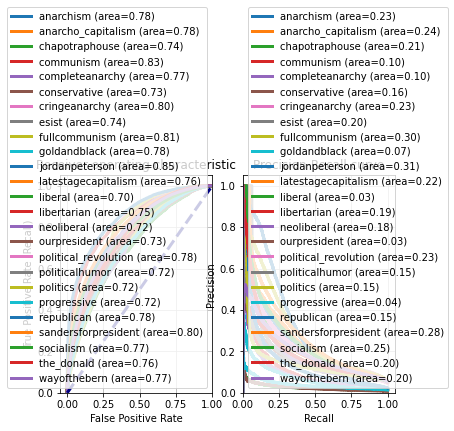

In [42]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
#NMI score with geometric average as in Strehl and Ghosh
print(metrics.normalized_mutual_info_score(y_test, predicted, average_method='geometric'))


fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()